In [1]:
# Colab may need these packages installed
#!apt install libgraphviz-dev
#!pip install pygraphviz
#%pip install dowhy graphviz pygraphviz

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import graphviz as gr
import statsmodels.formula.api as smf
from tqdm import trange
from dowhy import CausalModel

In [ ]:
def simulate(**kwargs):
  values = {}
  for k,v in kwargs.items():
    inputs = {arg: values[arg] for arg in v.__code__.co_varnames}
    values[k] = v(**inputs)
  return pd.DataFrame(values)

# Rule 1: Controlling for confounders

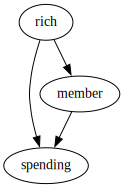

In [ ]:
g = gr.Digraph()
g.edge("rich", "spending")
g.edge("rich", "member")
g.edge("member", "spending")
g

In [ ]:
true_effect = 50

def get_data_1(N):
  return simulate(
      rich = lambda: np.random.binomial(1, 0.05, N),
      member = lambda rich: np.random.binomial(1, 0.20 + 0.20*rich, N),
      spending = lambda rich, member: 
        200*rich + true_effect*member + np.random.normal(500,100,N),
  )
df = get_data_1(100000)

In [ ]:
def diff_means(df):
  return df[df.member == 1].spending.mean() \
    - df[df.member == 0].spending.mean() 

def diff_means_by_group(df, group_var):
  group_1 = df[df[group_var] == 1]
  group_0 = df[df[group_var] == 0]
  
  group_1_mean = diff_means(group_1)
  group_0_mean = diff_means(group_0)

  group_1_frac = df[group_var].mean()

  return group_1_mean * group_1_frac + group_0_mean * (1-group_1_frac)

In [ ]:
df.groupby('member').spending.mean()

member
0    507.585061
1    568.499893
Name: spending, dtype: float64

In [ ]:
df.groupby('rich').apply(diff_means)

rich
0    48.985827
1    49.445261
dtype: float64

In [ ]:
# Do regression without controlling for rich
result = smf.ols('spending ~ member', data=df).fit()
print(result.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    507.5851      0.387   1310.870      0.000     506.826     508.344
member        60.9148      0.844     72.162      0.000      59.260      62.569


In [ ]:
# Do regression controlling for rich
result = smf.ols('spending ~ rich*member', data=df).fit()
print(result.summary().tables[1])

                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     500.1815      0.362   1380.097      0.000     499.471     500.892
rich          199.0383      1.879    105.918      0.000     195.355     202.721
member         48.9858      0.810     60.442      0.000      47.397      50.574
rich:member     0.4594      2.992      0.154      0.878      -5.406       6.324


### What distribution of predictions would we get if we repeated the process many times?

In [ ]:
N_obs = 1000
N_sims = 1000

100%|██████████| 1000/1000 [00:00<00:00, 2641.41it/s]


Nobs: 1000, Nsim: 1000
Mean: 61.581379158060734, SD: 8.386114939674373


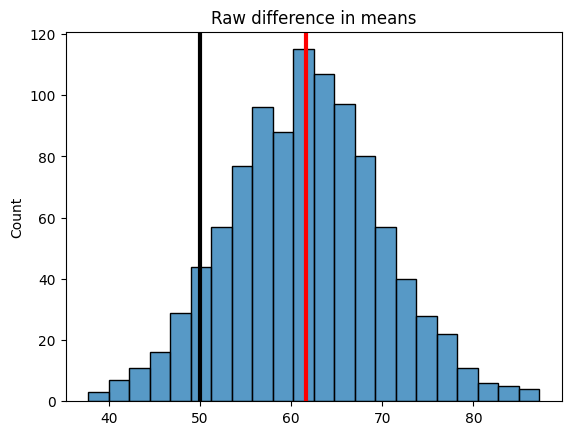

In [ ]:
# We do not learn the true effect of membership if we look at the raw difference in means
outputs = [diff_means(get_data_1(N_obs)) for _ in trange(N_sims)]
fig = sns.histplot(outputs)
fig.set_title("Raw difference in means") 
fig.axvline(np.mean(outputs), color="red", linewidth=3)
fig.axvline(true_effect, color="black", linewidth=3)
print(f"Nobs: {N_obs}, Nsim: {N_sims}")
print(f"Mean: {np.mean(outputs)}, SD: {np.std(outputs)}")

100%|██████████| 1000/1000 [00:00<00:00, 1214.67it/s]

Nobs: 1000, Nsim: 1000
Mean: 50.00112008395128, SD: 8.080600367864632


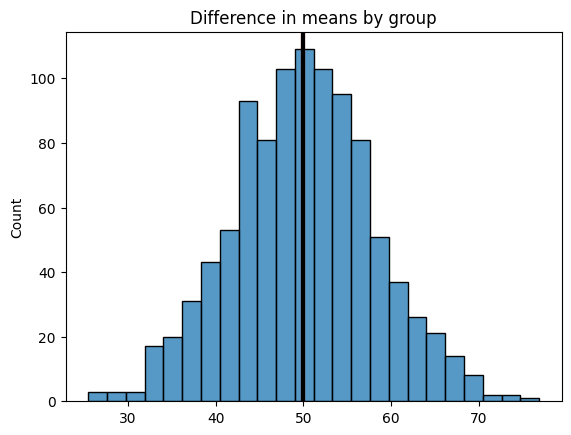

In [ ]:
# But we do if we calculate the effect of membership seperately for each group
outputs = [diff_means_by_group(get_data_1(N_obs), "rich") for _ in trange(N_sims)]
fig = sns.histplot(outputs)
fig.set_title("Difference in means by group")
fig.axvline(np.mean(outputs), color="red", linewidth=3)
fig.axvline(true_effect, color="black", linewidth=3)
print(f"Nobs: {N_obs}, Nsim: {N_sims}")
print(f"Mean: {np.mean(outputs)}, SD: {np.std(outputs)}")

# Rule 2: Don't control for mediators

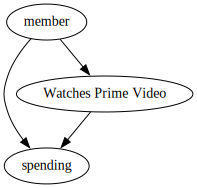

In [ ]:
g = gr.Digraph()
g.edge("member", "spending")
g.edge("member", "Watches Prime Video")
g.edge("Watches Prime Video", "spending")
g

In [ ]:
direct_effect = 50
increase_in_video_prob = 0.20
video_effect = 50
def get_data_2(N):
  return simulate(
      member = lambda: np.random.binomial(1, 0.20, N),
      video = lambda member: np.random.binomial(1, 0.05 + increase_in_video_prob*member, N),
      spending = lambda member, video: 
        true_effect*member + video_effect*video + np.random.normal(500,100,N),
  )
df = get_data_2(1000)

total_effect = true_effect + video_effect*increase_in_video_prob

In [ ]:
N_obs = 10000
N_sims = 1000

100%|██████████| 1000/1000 [00:00<00:00, 1097.11it/s]

Nobs: 10000, Nsim: 1000
Mean: 60.034366558373, SD: 2.599429055982614
Total effect: 60.0, Direct Effect 50


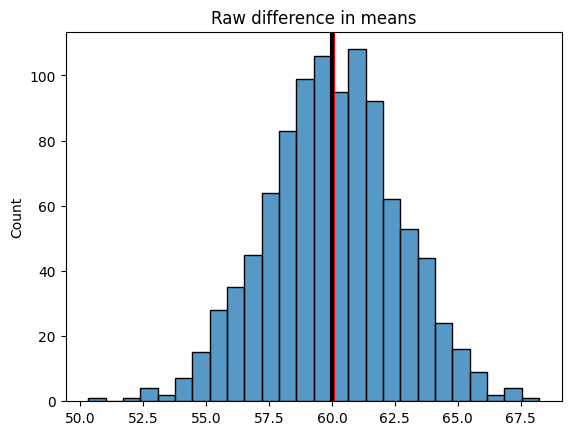

In [ ]:
# If we look at raw difference in means, then we estimate the full effect of membership on spending
outputs = [diff_means(get_data_2(N_obs)) for _ in trange(N_sims)]
fig = sns.histplot(outputs)
fig.set_title("Raw difference in means") 
fig.axvline(np.mean(outputs), color="red", linewidth=3)
fig.axvline(total_effect, color="black", linewidth=3)
print(f"Nobs: {N_obs}, Nsim: {N_sims}")
print(f"Mean: {np.mean(outputs)}, SD: {np.std(outputs)}")
print(f"Total effect: {total_effect}, Direct Effect {direct_effect}")

100%|██████████| 1000/1000 [00:01<00:00, 640.58it/s]

Nobs: 10000, Nsim: 1000
Mean: 49.90990298131199, SD: 2.5774959936923594
Total effect: 60.0, Direct Effect 50


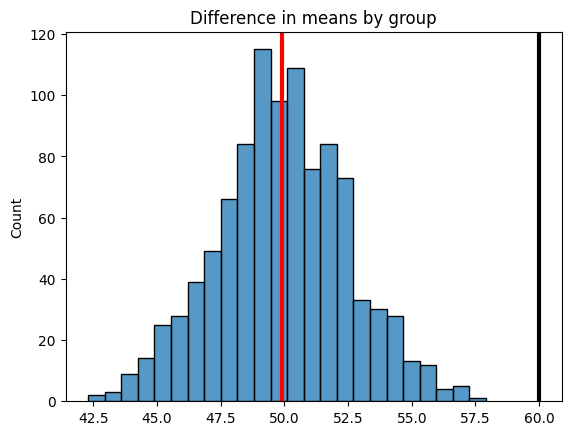

In [ ]:
# If we control for video, then we estimate only the direct effect of membership
outputs = [diff_means_by_group(get_data_2(N_obs), "video") for _ in trange(N_sims)]
fig = sns.histplot(outputs)
fig.set_title("Difference in means by group")
fig.axvline(np.mean(outputs), color="red", linewidth=3)
fig.axvline(total_effect, color="black", linewidth=3)
print(f"Nobs: {N_obs}, Nsim: {N_sims}")
print(f"Mean: {np.mean(outputs)}, SD: {np.std(outputs)}")
print(f"Total effect: {total_effect}, Direct Effect {direct_effect}")

# Rule 3: Controlling for outcome predictors

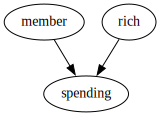

In [ ]:
g = gr.Digraph()
g.edge("member", "spending")
g.edge("rich", "spending")
g

In [ ]:
def get_data_3(N):
  return simulate(
      rich = lambda: np.random.binomial(1, 0.05, N),
      member = lambda: np.random.binomial(1, 0.20, N),
      spending = lambda rich, member: 
        10000*rich + true_effect*member + np.random.normal(500,100,N),
  )
df = get_data_3(1000)

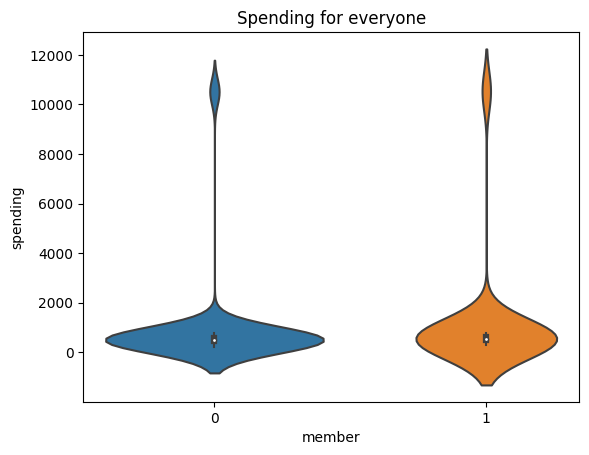

In [ ]:
fig = sns.violinplot(data=df, x='member', y='spending')
fig.set_title("Spending for everyone")
fig.plot()

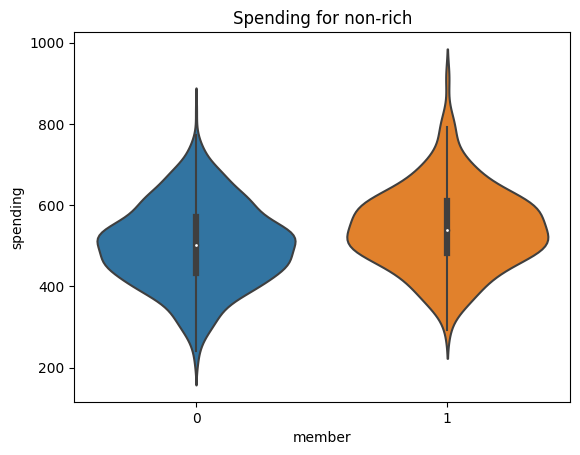

In [ ]:
fig = sns.violinplot(data=df[df.rich == 0], x='member', y='spending')
fig.set_title("Spending for non-rich")
fig.plot()

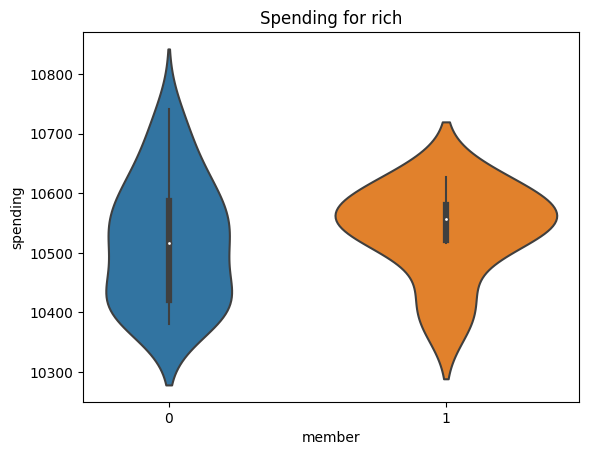

In [ ]:
fig = sns.violinplot(data=df[df.rich == 1], x='member', y='spending')
fig.set_title("Spending for rich")
fig.plot()

### What distribution of predictions would we get if we repeated the process many times?


In [ ]:
N_obs = 1000
N_sims = 1000

100%|██████████| 1000/1000 [00:00<00:00, 2550.49it/s]


Nobs: 1000, Nsim: 1000
Mean: 53.19399051657045, SD: 171.47650102182203


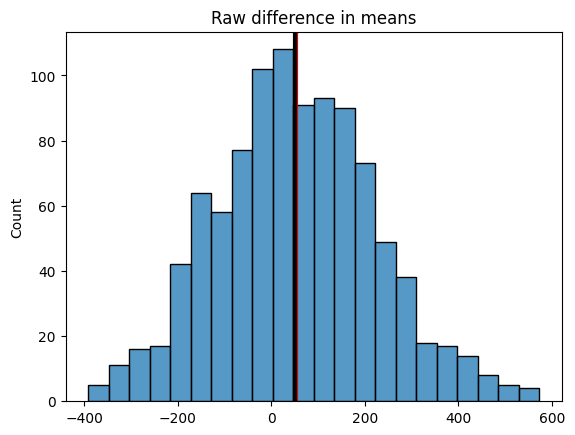

In [ ]:
outputs = [diff_means(get_data_3(N_obs)) for _ in trange(N_sims)]
fig = sns.histplot(outputs)
fig.set_title("Raw difference in means") 
fig.axvline(np.mean(outputs), color="red", linewidth=3)
fig.axvline(true_effect, color="black", linewidth=3)
print(f"Nobs: {N_obs}, Nsim: {N_sims}")
print(f"Mean: {np.mean(outputs)}, SD: {np.std(outputs)}")

### We can get a much more precise answer if we calculate the impact separately by rich/non-rich group

100%|██████████| 1000/1000 [00:00<00:00, 1130.30it/s]


Nobs: 1000, Nsim: 1000
Mean: 49.806097308682936, SD: 7.674968021143384


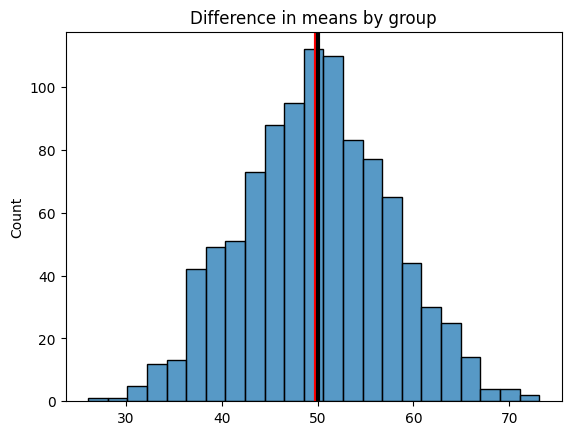

In [ ]:
outputs = [diff_means_by_group(get_data_1(N_obs), "rich") for _ in trange(N_sims)]
fig = sns.histplot(outputs)
fig.set_title("Difference in means by group")
fig.axvline(np.mean(outputs), color="red", linewidth=3)
fig.axvline(true_effect, color="black", linewidth=3)
print(f"Nobs: {N_obs}, Nsim: {N_sims}")
print(f"Mean: {np.mean(outputs)}, SD: {np.std(outputs)}")

## We can still get an unbiased estimate without controlling for Rich
## But it takes more data to get a precise estimate

100%|██████████| 1000/1000 [00:05<00:00, 183.49it/s]


Nobs: 100000, Nsim: 1000
Mean: 49.25383611376684, SD: 17.378776408312987


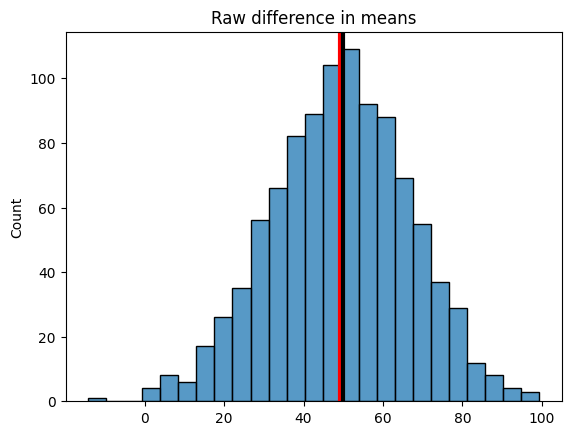

In [ ]:
large_n = 100000
outputs = [diff_means(get_data_3(large_n)) for _ in trange(N_sims)]
fig = sns.histplot(outputs)
fig.set_title("Raw difference in means") 
fig.axvline(np.mean(outputs), color="red", linewidth=3)
fig.axvline(true_effect, color="black", linewidth=3)
print(f"Nobs: {large_n}, Nsim: {N_sims}")
print(f"Mean: {np.mean(outputs)}, SD: {np.std(outputs)}")

# Automating the process with DoWhy

## A more complex graph

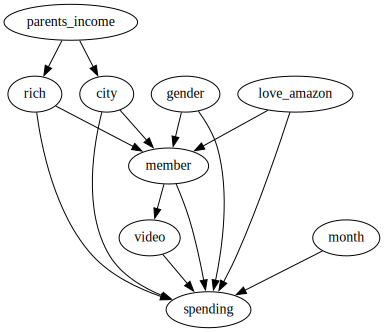

In [ ]:
g = gr.Digraph()
g.edge("parents_income", "rich")
g.edge("parents_income", "city")
g.edge("rich", "member")
g.edge("rich", "spending")
g.edge("gender", "member")
g.edge("gender", "spending")
g.edge("city", "member")
g.edge("city", "spending")
g.edge("love_amazon", "spending")
g.edge("love_amazon", "member")
g.edge("member", "spending")
g.edge("member", "video")
g.edge("video", "spending")
g.edge("month", "spending")
g

In [ ]:
N = 100000
df = simulate(
  rich = lambda: np.random.binomial(1, 0.05, N),
  city = lambda: np.random.binomial(1, 0.05, N),
  gender = lambda: np.random.binomial(1, 0.50, N),
  love_amazon = lambda rich, city: np.random.binomial(1, 0.05 + 0.05*rich + 0.05*city, N),
  member = lambda city, rich, love_amazon, gender: 
    np.random.binomial(1, 0.20 + 0.20*rich + 0.05*city + 0.2*love_amazon + 0.01*gender, N),
  spending = lambda city, rich, love_amazon, gender, member: 
    city*10 + rich*100 + love_amazon*200 + member*50 + gender*10 + np.random.normal(500,100,N),
)
  

In [ ]:
model = CausalModel(
    data = df,
    treatment = 'member',
    outcome = 'spending',
    graph = g.__str__()
)

In [ ]:
estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                              
─────────(E[spending|rich,love_amazon,city,gender])
d[member]                                          
Estimand assumption 1, Unconfoundedness: If U→{member} and U→spending then P(spending|member,rich,love_amazon,city,gender,U) = P(spending|member,rich,love_amazon,city,gender)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [ ]:
estimate = model.estimate_effect(estimand, method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['month']}
Causal Estimate is 49.72867260839996


### What if we do not observe love_amazon?

In [ ]:
df.drop("love_amazon", axis=1, inplace=True)
model = CausalModel(
    data = df,
    treatment = 'member',
    outcome = 'spending',
    graph = g.__str__()
)

In [ ]:
estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [ ]:
estimate = model.estimate_effect(estimand, method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

linear_regression
Causal Estimate is None


## Questions for next time
* What happens when I have a large number of groups to control for?